In [7]:
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from huggingface_hub import HfApi


In [8]:
checkpoints = [
    "henryscheible/bert-large-uncased_stereoset_finetuned",
    "henryscheible/bert-large-uncased_winobias_finetuned",
    "henryscheible/bert-large-uncased_crows_pairs_finetuned",
    "henryscheible/xlnet-base-cased_stereoset_finetuned",
    "henryscheible/xlnet-base-cased_winobias_finetuned",
    "henryscheible/xlnet-base-cased_crows_pairs_finetuned",
]

In [9]:
from plmbias.models import ModelEnvironment

data = {}
for checkpoint in checkpoints:
    data[checkpoint] = json.loads(requests.get(f"https://huggingface.co/{checkpoint}/raw/main/results.json").text)
    model_env = ModelEnvironment.from_pretrained(checkpoint)
    data[checkpoint]["mask_shape"] = model_env.get_mask_shape()

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/979 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/979 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/979 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

In [13]:
def generate_heatmap(checkpoint, contribs, mask_shape):
    sns.set(font_scale=1.2)
    matrix = np.flip(np.array(contribs).reshape(mask_shape))
    xticklabels = list(np.arange(matrix.shape[1]) + 1)
    yticklabels = list(matrix.shape[0] - np.arange(matrix.shape[0]))
    ax = plt.gca()
    sns.heatmap(matrix, ax=ax, cmap="PiYG", center=0, xticklabels=xticklabels, yticklabels=yticklabels, square=True, cbar=False)
    ax.set(
        xlabel="Head",
        ylabel="Layer"
    )
    model_name = checkpoint.split("/")[1]
    plt.savefig(f"results/{model_name}_heatmap.pdf", bbox_inches="tight", format="pdf")
    plt.show()
    api = HfApi()
    api.upload_file(
    path_or_fileobj=f"results/{model_name}_heatmap.pdf",
    path_in_repo=f"heatmap.pdf",
    repo_id=checkpoint,
    repo_type="model",
)

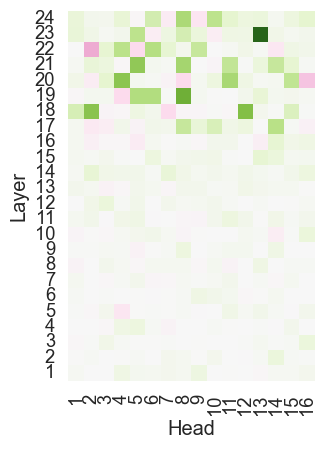

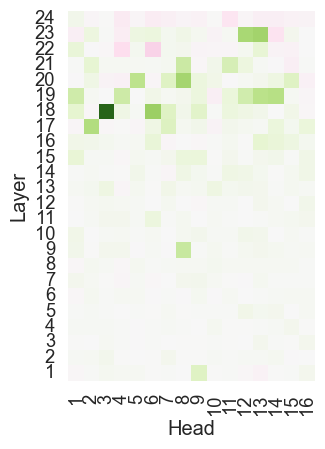

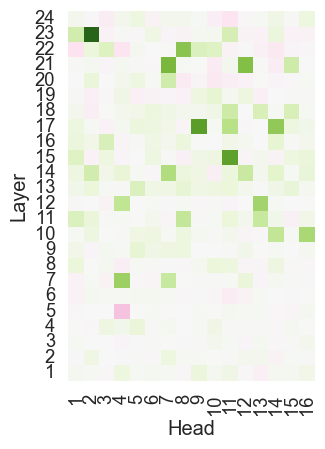

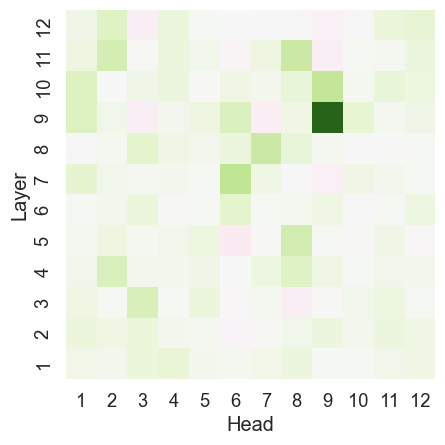

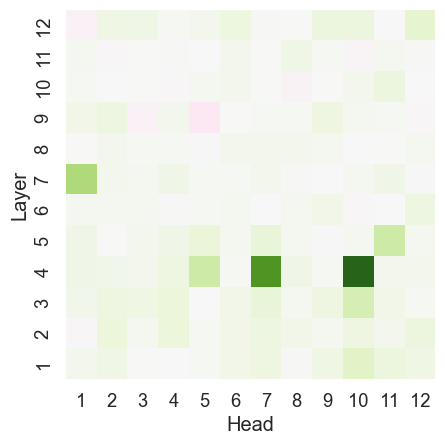

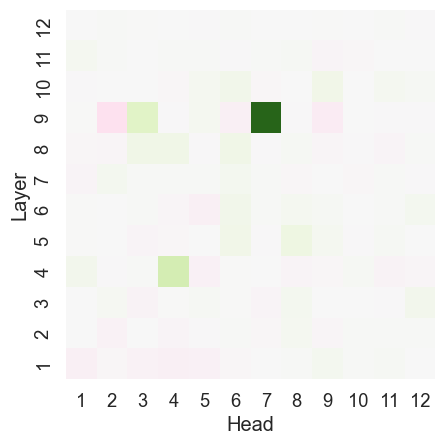

[None, None, None, None, None, None]

In [14]:
[generate_heatmap(checkpoint, result["contribs"], result["mask_shape"]) for checkpoint, result in data.items()]

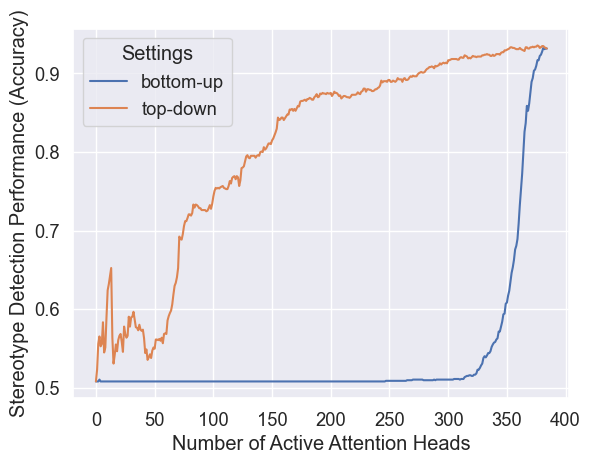

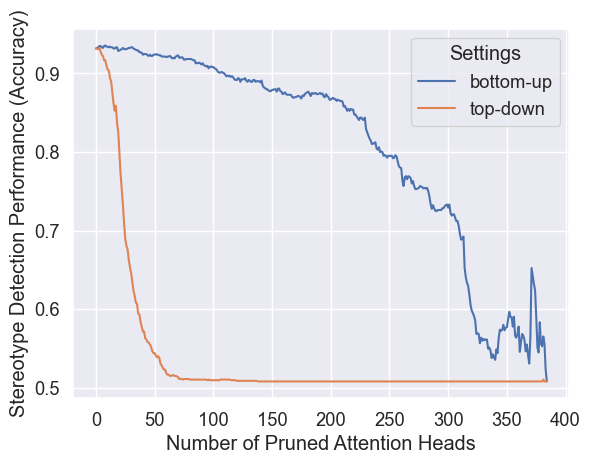

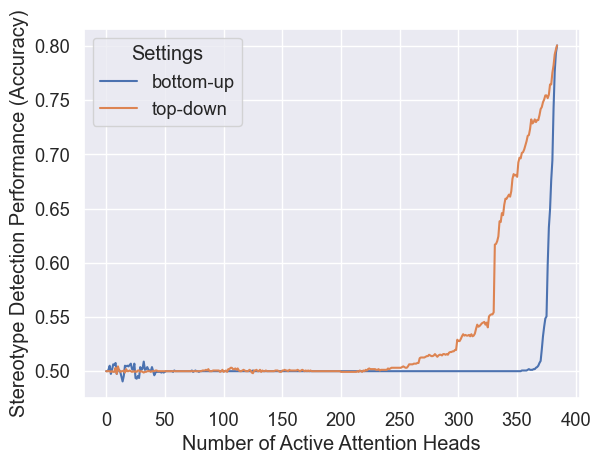

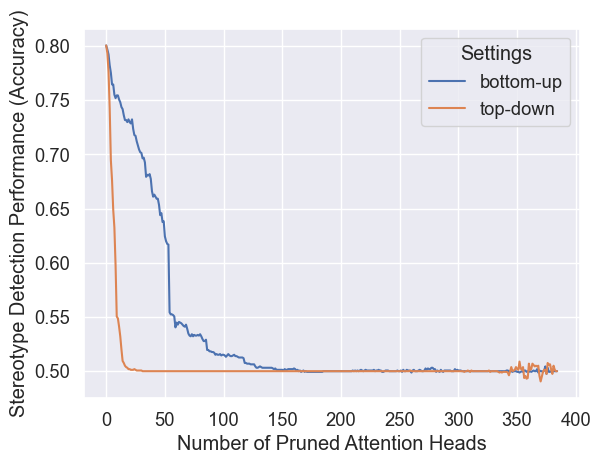

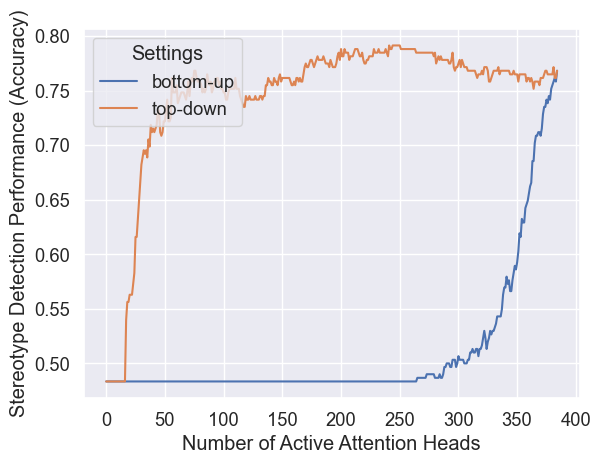

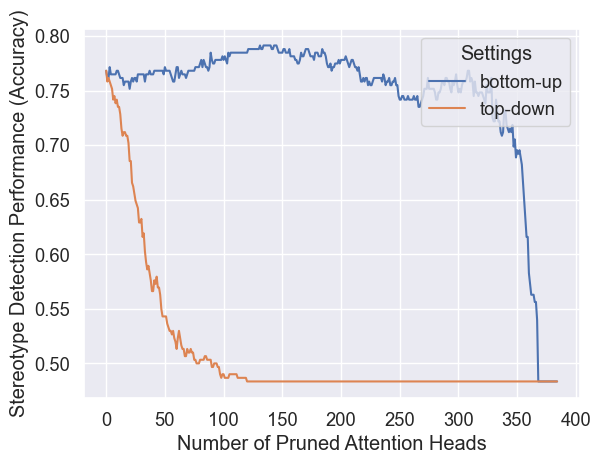

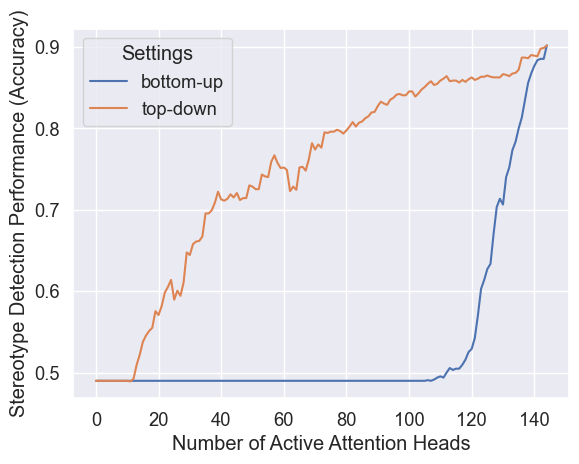

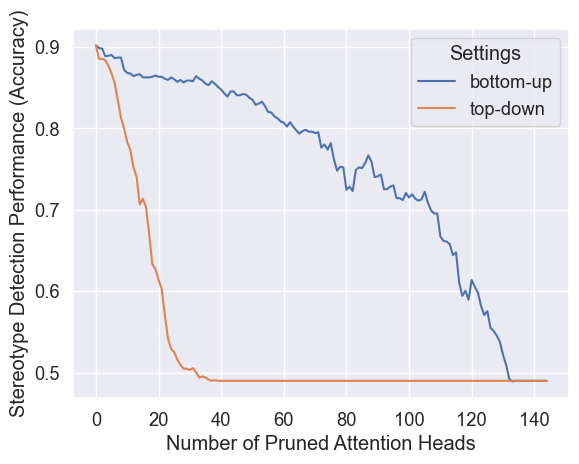

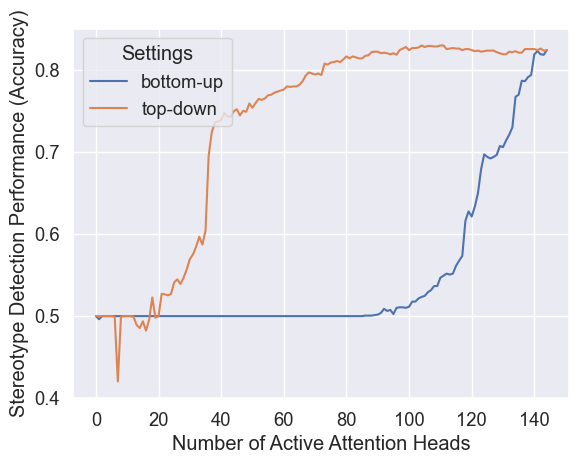

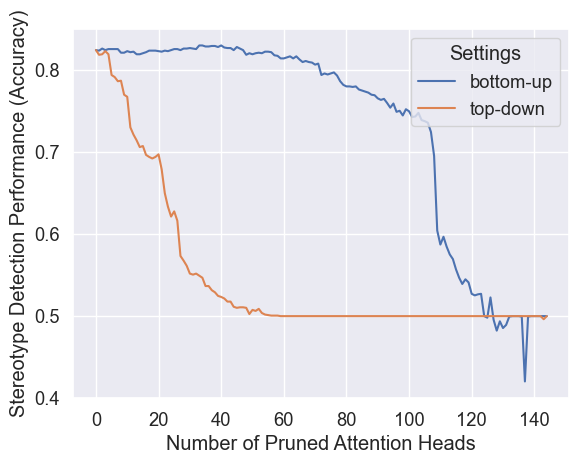

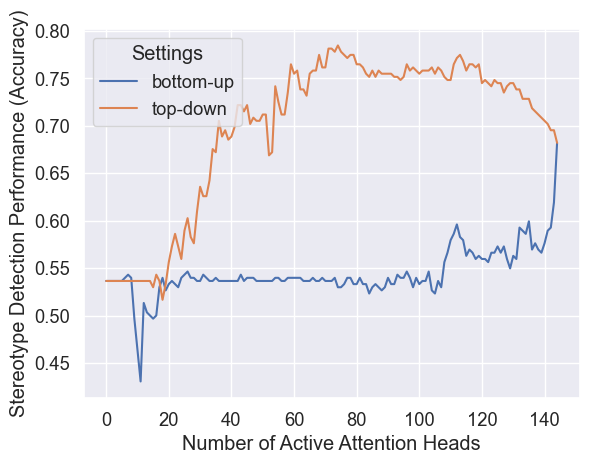

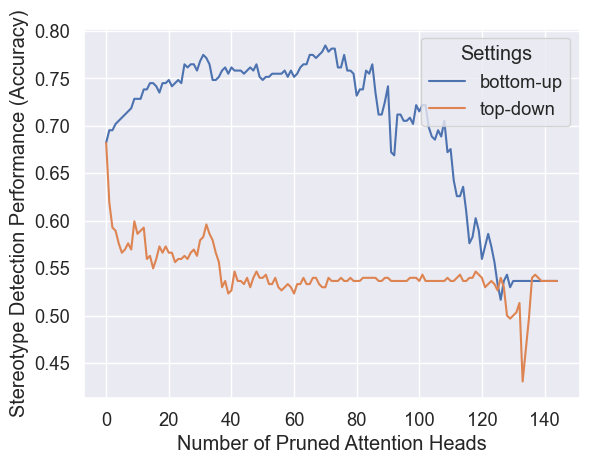

In [12]:
def generate_figure(checkpoint, results):
    sns.set(font_scale=1.2)
    df = pd.DataFrame({
        'heads': np.arange(len(results["contribs"]) + 1),
        'bottom-up': results["bottom_up_results"],
        'top-down': results["bottom_up_rev_results"],
    })
    melted_df = pd.melt(df, ['heads']).rename(columns={"variable": "Settings"})
    ax = sns.lineplot(x='heads', y='value', hue='Settings',
                data=melted_df)
    ax.set(xlabel="Number of Active Attention Heads", ylabel="Stereotype Detection Performance (Accuracy)")
    plt.legend(loc="upper left", title="Settings")
    model_name = checkpoint.split("/")[1]
    plt.savefig(f"results/{model_name}_add_ablation.pdf", format="pdf")
    plt.show()

    df = pd.DataFrame({
        'heads': np.arange(len(results["contribs"])+1),
        'bottom-up': results["top_down_results"],
        'top-down': results["top_down_rev_results"],
    })
    melted_df = pd.melt(df, ['heads']).rename(columns={"variable": "Settings"})
    ax = sns.lineplot(x='heads', y='value', hue='Settings',
                data=melted_df)
    ax.set(xlabel="Number of Pruned Attention Heads", ylabel="Stereotype Detection Performance (Accuracy)")
    plt.legend(loc="upper right", title="Settings")
    model_name = checkpoint.split("/")[1]
    plt.savefig(f"results/{model_name}_remove_ablation.pdf", format="pdf")
    plt.show()
    api = HfApi()
    api.upload_file(
    path_or_fileobj=f"results/{model_name}_add_ablation.pdf",
    path_in_repo=f"add_ablation.pdf",
    repo_id=checkpoint,
    repo_type="model")
    api.upload_file(
    path_or_fileobj=f"results/{model_name}_remove_ablation.pdf",
    path_in_repo=f"remove_ablation.pdf",
    repo_id=checkpoint,
    repo_type="model")


for checkpoint, results in data.items():
    generate_figure(checkpoint, results)